In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional
import pandas as pd
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
# from b2aiprep.process import Audio, specgram, plot_spectrogram
from senselab.audio.data_structures.audio import Audio
from senselab.audio.tasks.features_extraction.torchaudio import extract_spectrogram_from_audios
from senselab.audio.tasks.preprocessing.preprocessing import resample_audios
from senselab.audio.tasks.plotting.plotting import plot_specgram
				# audio = Audio.from_filepath(location + ".wav")
			    # audio = resample_audios([audio])[0]
import IPython.display as Ipd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


### Audiorecordings(from lectures)

dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])


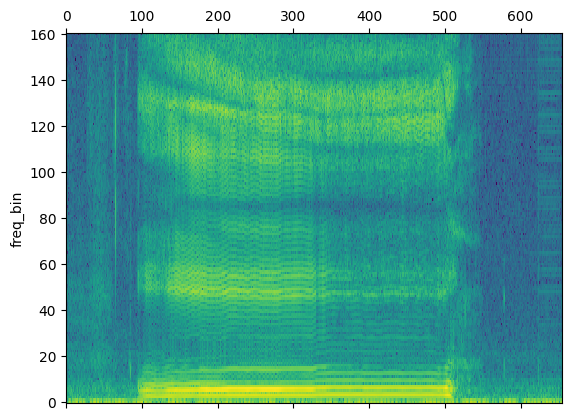

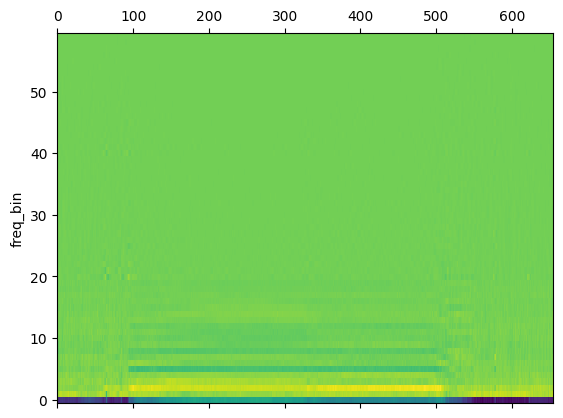

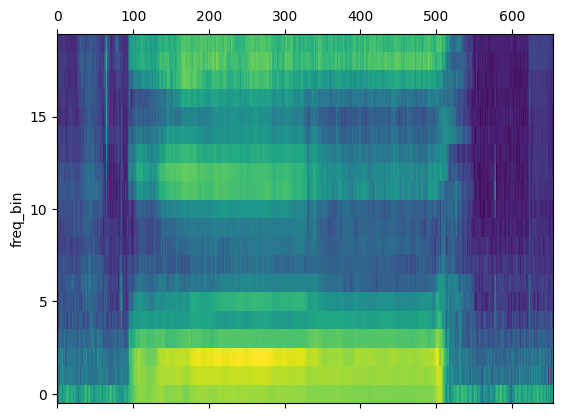

In [3]:
dataset = VBAIDataset('../bids_with_sensitive_recordings')
path = '../bids_with_sensitive_recordings/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e/ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371/audio/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e_ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371_Prolonged-vowel_rec-Prolonged-vowel'
data = torch.load(path + '.pt')
melfilterbank = data["melfilterbank"]
print(data.keys())
mfcc = data["mfcc"]
pt_spec = data["specgram"]
audio = Audio.from_filepath(path + '.wav')
audio = resample_audios([audio], resample_rate=16000)[0]
win_length = 20
hop_length = 10
nfft = None
features_specgram = extract_spectrogram_from_audios([audio],  win_length=win_length, hop_length=hop_length, n_fft=nfft)
features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T
pt_features_specgram = 10.0 * torch.log10(torch.maximum(pt_spec, torch.full(pt_spec.size(), fill_value=1e-10))).T
plot_specgram(features_specgram, audio.sampling_rate)
plot_specgram(mfcc.T, audio.sampling_rate)
plot_specgram(melfilterbank.T, audio.sampling_rate)

### Demographics

In [4]:
dg = pd.read_csv('../demographics.csv')
dg.head(1)

,Unnamed: 0,record_id,demographics_session_id,demographics_duration,demographics_completed_by___1,demographics_completed_by___2,demographics_completed_by___3,state_province,country,gender_identity,...,household_count,spouse_partner_sig_other,children,parent,grandparent,other_live_with,others_household_specify,transportation_yn,primary_transportation,q_generic_demographics_complete
0,0,8d5dc52b-e8aa-42e7-ae54-8f05c4667d39,B176636C-3330-4AB4-93A9-1E2305506407,173.0,True,False,False,Tennessee,USA,Female gender identity,...,4.0,No,Yes,Yes,No,No,NaN,Yes,Personal vehicle,Complete


In [5]:
Train = dg[["record_id", "demographics_session_id", "household_income_usa", "household_income_ca", "household_count"]]
Train.head(3)

,record_id,demographics_session_id,household_income_usa,household_income_ca,household_count
0,8d5dc52b-e8aa-42e7-ae54-8f05c4667d39,B176636C-3330-4AB4-93A9-1E2305506407,"$15,000 to $29,999",NaN,4.0
1,1b07b18b-26f9-405b-a466-29442306a7fe,8F8E68BB-E68C-4EA5-B71A-17D7AAE915C2,NaN,"$150,000 to $199,999",4.0
2,e5db3e0c-6589-4a15-a5e7-8a95e4ed34a5,B94FE4BC-79FF-46A1-86CC-628E2D77874E,NaN,"$50,000 to $99,999",1.0


In [6]:
print("Shape before filtering: ",Train.shape)
pre_train = Train[(pd.notna(Train['household_income_usa']) | pd.notna(Train['household_income_ca'])) &
                                   (~((Train['household_income_usa'] == 'Prefer not to answer') | 
                                      (Train['household_income_ca'] == 'Prefer not to answer')))]
print("Shape after filtering: ", pre_train.shape)


Shape before filtering:  (179, 5)
Shape after filtering:  (115, 5)


In [7]:
#label data: 0 - poverty, 1 - lower, 2 - middle, 3 - upper
pre_train_labeled = pd.DataFrame(pre_train)

for index, row in pre_train.iterrows():
    if pd.notna(pre_train.loc[index, "household_income_usa"]) and pre_train.loc[index, "household_count"] >= 3: # USD; HH >= 3
        income = pre_train.loc[index, "household_income_usa"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
    
    elif pd.notna(pre_train.loc[index, "household_income_usa"]): # USD; HH < 3
        income = pre_train.loc[index, "household_income_usa"]
        if income in ['< $15,000']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$15,000 to $29,999', '$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
        
    elif pd.notna(pre_train.loc[index, "household_income_ca"]):  # CA; HH >= 3
        income = pre_train.loc[index, "household_income_ca"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_ca")
    else:
        print(index)
        
   
y = pd.get_dummies(pre_train_labeled['SES'], prefix='SES').astype(int)
X = pre_train_labeled[['record_id', 'demographics_session_id', 'SES']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
# train_df = pd.concat([X_train, y_train], axis=1)
# val_df = pd.concat([X_val, y_val], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

# train_val = pd.concat([train_df, val_df], axis = 0)
# pre_train_labeled = pd.concat([train_val, test_df], axis = 0)
# display(pre_train_labeled)

### Audiofiles

In [19]:
# rainbow, story recall, Picture description
class RainbowMelfilterBankDatasetWithMultisampling(torch.utils.data.Dataset):
	def __init__(self, data, segment_size):
		self.segment_size = segment_size
		self.data = data
		# self.data[target_diagnosis] = self.data[target_diagnosis].astype(float)
		self.data.reset_index(drop=True, inplace=True)
		
		# get location for every recording of rainbow passage // generate multiple samples per recording
		index = 0
		while index < len(self.data):
			row = self.data.iloc[index]
			if not pd.notna(row['record_id']):
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				# index += 1
				# display("dropped", row)
				continue
			subject = "sub-" + row['record_id']
			session = "ses-" + row['demographics_session_id']
			location = str("../bids_with_sensitive_recordings/" + subject + "/" + session + '/audio/'+subject+"_"+session+"_Rainbow-Passage_rec-Rainbow-Passage")
			if os.path.exists(location + '.wav'):
				self.data.at[index, "location"] = location
				self.data.at[index, "segment"] = 0
                audio = Audio.from_filepath(location + ".wav")
                audio = resample_audios(audio, resample_rate=16000)[0]
                audio.waveform = audio.waveform.squeeze()
				num_segments = audio.waveform.shape[-1] // 160 // self.segment_size #audio size mapping to spectrogram size
    			#insert num_segment rows with different segment number(each record is different timeframe of the same recording)
				count = 1
				while count < num_segments:
					row_to_copy = self.data.iloc[index]
					row_df = pd.DataFrame([row_to_copy])
					self.data = pd.concat([self.data.iloc[:index+1], row_df, self.data.iloc[index+1:]]).reset_index(drop=True)
					index += 1
					self.data.at[index, "segment"] = count
					count += 1

			else:
				# print all patients without Rainbow passage recording   
				# print("Location does not exist ", location)
				data.at[index, "location"] = "DNE"
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				index-=1
			index += 1
		self.data.reset_index(drop=True, inplace=True)


	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		if not os.path.exists(self.data.loc[idx, "location"]+'.pt'):
			display("error", self.data.loc[idx, "location"])
		torch_data = torch.load(self.data.loc[idx, "location"]+'.pt')
		melfilterbank = torch_data["melfilterbank"]
		if melfilterbank.shape[0] >= self.segment_size:
			seg_num = self.data.loc[idx, "segment"]
			max_seg_size = melfilterbank.size(0) // self.segment_size
	
			start = (melfilterbank.size(0) - self.segment_size * max_seg_size) // 2
			start = int(start + self.segment_size * seg_num)

			melfilterbank = melfilterbank[start:start+self.segment_size, :]
		else:
			rows_to_add = max(0, self.segment_size - melfilterbank.shape[0])
			melfilterbank = torch.nn.functional.pad(melfilterbank, (0, 0, 0, rows_to_add), mode='constant', value=0)
  
		ses = self.data.loc[idx, ["SES_0.0", "SES_1.0", "SES_2.0", "SES_3.0"]].to_numpy(dtype=np.float32)
		ses = torch.tensor(ses, dtype=torch.float32)
		
		return {'signal': melfilterbank.T, 'SES': ses}


In [9]:
# pre_train_labeled.reset_index(drop=True, inplace=True)
# test = pre_train_labeled.loc[ :, ['record_id', 'demographics_session_id', 'SES', 'SES_0.0', 'SES_1.0', 'SES_2.0', 'SES_3.0']]
# display(test.loc[57:59])
# # dataset = RainbowMelfilterBankDatasetWithMultisampling(test, 500)

In [29]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_dataset = RainbowMelfilterBankDatasetWithMultisampling(train_df, 400)
val_dataset = RainbowMelfilterBankDatasetWithMultisampling(val_df, 400)
test_dataset = RainbowMelfilterBankDatasetWithMultisampling(test_df, 400)

print("Perform data check:")
check_loc_1 = train_dataset.data[~train_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
check_loc_2 = val_dataset.data[~val_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
check_loc_3 = test_dataset.data[~test_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tAll locations are not NaN")
else:
    print("\tFound incorrect locations")
    
check_dublicates_1 = train_dataset.data[train_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_2 = val_dataset.data[val_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_3 = test_dataset.data[test_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tNo dublicates were generated")
else:
    print("\tCheck dublicated values!")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=30, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=30, shuffle=False)

for batch in val_dataloader:
    print(batch['signal'].shape)
    break

Perform data check:
	All locations are not NaN
	No dublicates were generated
torch.Size([30, 20, 400])


### CNN Model

In [58]:
class CNN_1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(20, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)                                                                           
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Calculate the input size to the first linear layer
        self.fc_input_size = self._calculate_fc_input_size()
  
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        x = self.mp(self.bn2(torch.nn.functional.relu(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(x)  # Apply dropout before the linear layers
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def _calculate_fc_input_size(self):
        x = torch.randn(1, 20, 400)
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        x = self.mp(self.bn2(torch.nn.functional.relu(self.conv2(x))))
        return x.view(x.size(0), -1).size(1)


In [59]:
# cnn = CNN_1D(4)
cnn = CNN_1D(num_classes=4)
_ = summary(cnn, (20, 400))
# for batch in train_dataloader:
#     out = cnn(batch['signal'].unsqueeze(1)).squeeze(1)[0]
#     out = torch.tensor([0.1, 0.2, 1, 10])
#     print(out)
#     print(torch.nn.functional.softmax(out))
#     print()
#     break

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 400]           6,464
       BatchNorm1d-2              [-1, 64, 400]             128
         MaxPool1d-3              [-1, 64, 200]               0
            Conv1d-4             [-1, 128, 200]          41,088
       BatchNorm1d-5             [-1, 128, 200]             256
         MaxPool1d-6             [-1, 128, 100]               0
           Dropout-7                [-1, 12800]               0
            Linear-8                  [-1, 128]       1,638,528
            Linear-9                   [-1, 64]           8,256
           Linear-10                    [-1, 4]             260
Total params: 1,694,980
Trainable params: 1,694,980
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.08
Params size (MB): 6.47
Estimat

In [60]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    total = 0
    all_predictions = []
    all_ground_truths = []
    for batch in dataloader:
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(batch['signal']), dim=1)
            _, predicted = torch.max(outputs, 1)
            _, ground_truth = torch.max(batch['SES'], 1)
            acc += (predicted == ground_truth).sum().item()
            total += ground_truth.size(0)
            all_predictions.extend(predicted.cpu().numpy())
            all_ground_truths.extend(ground_truth.cpu().numpy())
    return acc / total, all_predictions, all_ground_truths	

optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

num_epochs = 25
best_val_acc = 0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn.train()
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = cnn(batch['signal'])
        loss = criterion(outputs, batch['SES'].argmax(dim=1))
        closs += [loss.item()] * len(batch['signal'])
        loss.backward()
        optimizer.step()
    scheduler.step()
    train_loss = sum(closs) / len(closs)
    train_losses.append(train_loss)
    
    val_acc, _, _ = eval(cnn, val_dataloader)
    val_losses.append(train_loss)  # Assuming validation loss is same as train loss here
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), '../../models/spectrogram_1d_cnn_model.pt')
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Val Acc: {val_acc}')

Epoch 1/25, Loss: 1.4010449036830614, Val Acc: 0.25675675675675674
Epoch 2/25, Loss: 1.3793833682517043, Val Acc: 0.36486486486486486
Epoch 3/25, Loss: 1.3644315657495452, Val Acc: 0.36486486486486486
Epoch 4/25, Loss: 1.3512335953592252, Val Acc: 0.3918918918918919
Epoch 5/25, Loss: 1.3356397226077168, Val Acc: 0.3918918918918919
Epoch 6/25, Loss: 1.3188368062011333, Val Acc: 0.40540540540540543
Epoch 7/25, Loss: 1.3095507221061642, Val Acc: 0.4189189189189189
Epoch 8/25, Loss: 1.2912709967428897, Val Acc: 0.40540540540540543
Epoch 9/25, Loss: 1.2734788111277988, Val Acc: 0.3918918918918919
Epoch 10/25, Loss: 1.267359078230978, Val Acc: 0.40540540540540543
Epoch 11/25, Loss: 1.253718971204357, Val Acc: 0.4189189189189189
Epoch 12/25, Loss: 1.2454146974227007, Val Acc: 0.4189189189189189
Epoch 13/25, Loss: 1.2488158610688538, Val Acc: 0.4189189189189189
Epoch 14/25, Loss: 1.2466467965550783, Val Acc: 0.4189189189189189
Epoch 15/25, Loss: 1.2422721596325146, Val Acc: 0.40540540540540543

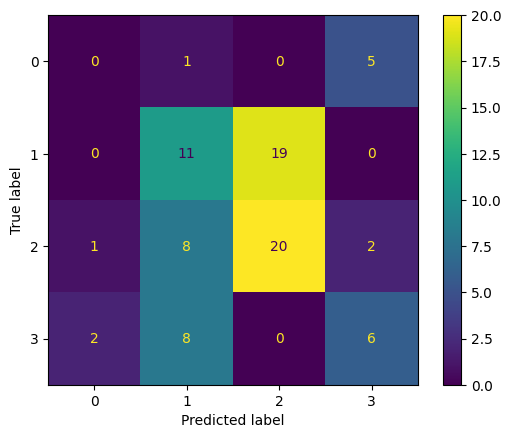

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         6
     Class 1       0.39      0.37      0.38        30
     Class 2       0.51      0.65      0.57        31
     Class 3       0.46      0.38      0.41        16

    accuracy                           0.45        83
   macro avg       0.34      0.35      0.34        83
weighted avg       0.42      0.45      0.43        83



In [61]:
_, predictions, ground_truths = eval(cnn, test_dataloader)
cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)

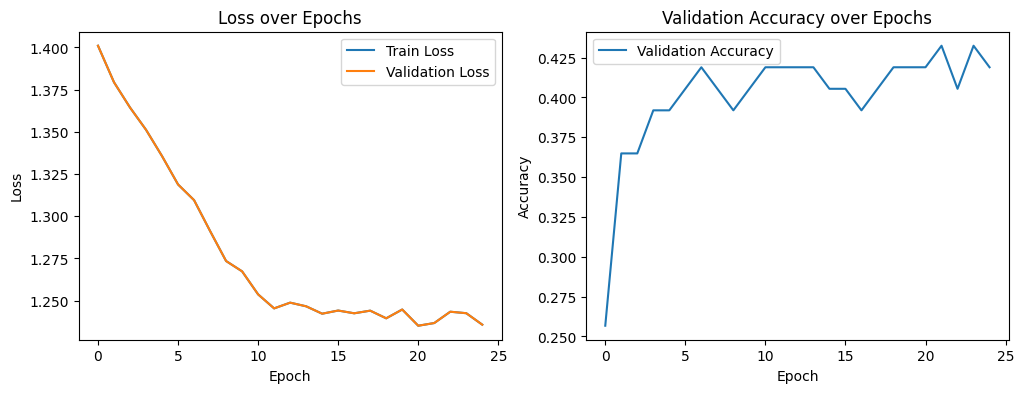

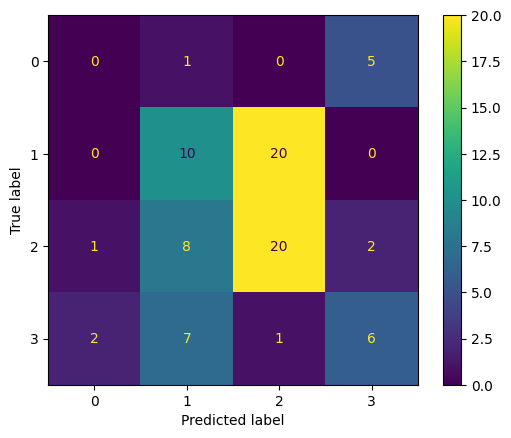

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         6
     Class 1       0.38      0.33      0.36        30
     Class 2       0.49      0.65      0.56        31
     Class 3       0.46      0.38      0.41        16

    accuracy                           0.43        83
   macro avg       0.33      0.34      0.33        83
weighted avg       0.41      0.43      0.42        83



In [62]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy over Epochs')
plt.show()

# Confusion matrix
cnn.load_state_dict(torch.load('../../models/spectrogram_1d_cnn_model.pt'))
_, predictions, ground_truths = eval(cnn, test_dataloader)

cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)